# No Drive so we do not do this.

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


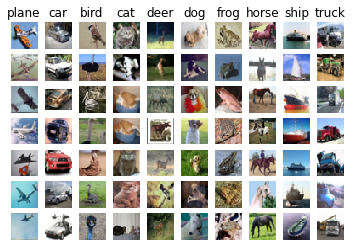

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
# we want images in a single row
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


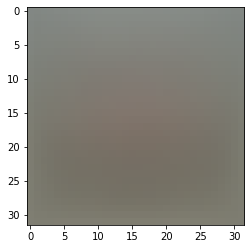

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# what is bias trick ??

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W. 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) # (49000, 3073)
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) # (1000, 3073)
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) # (1000, 3073)
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))]) # (500, 3073)


# before this hstack step
# X_train shape was Training data shape:  (49000, 3072)
# Now it is: (49000, 3073)
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# 3073 rows, 10 cols
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.810829


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 11.701586 analytic: 11.701586, relative error: 1.296208e-11
numerical: 23.910839 analytic: 23.910839, relative error: 1.659368e-11
numerical: 6.194796 analytic: 6.194796, relative error: 1.000979e-11
numerical: 2.566226 analytic: 2.566226, relative error: 7.938868e-11
numerical: 8.390865 analytic: 8.390865, relative error: 1.968176e-11
numerical: -46.772799 analytic: -46.772799, relative error: 7.349355e-12
numerical: -5.954381 analytic: -5.954381, relative error: 5.063583e-11
numerical: -11.293225 analytic: -11.293225, relative error: 9.297571e-12
numerical: 17.788676 analytic: 17.788676, relative error: 2.887549e-11
numerical: 14.680639 analytic: 14.680639, relative error: 2.779266e-11
numerical: 13.211661 analytic: 13.211661, relative error: 1.319267e-11
numerical: 3.185591 analytic: 3.185591, relative error: 5.544231e-12
numerical: 0.868607 analytic: 0.868607, relative error: 3.565828e-10
numerical: -35.425222 analytic: -35.425222, relative error: 1.324249e-11
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  

The SVM loss function was:

$$L = \sum_{j \neq yi} max(0, s_j - s_{yi} + 1 )$$  

for all classes in the training set.

If the `score_difference + margin > 0` then we are incurring some error, else if `score_difference + margin < 0` we are thresholding it to 0. 

The problem with the max function is when we try to calculate the gradients.

In general when we have max(x,y) and x=y the gradient is undefined, these non-differentiable parts of the function are known as `kinks` and they are the cause of fails in gradient check. 

As a simple example if x=-1e-8 then max(0,x)=0, the analytical gradient is 0; however, the numerical gradient might be different if we consider h greater than x, e.g., h=1e-6. 

It will be different because when we calculate f(x+h) = max(0,x+h) = c > 0, thus numerical gradient will be different than 0. 

To avoid the frequency of this problem, we might consider a small number of datapoints when calculating the gradient because with fewer datapoints, we will have fewer kinks. 

Additionally we can employ strategies such as gradient clipping, gradient normalization, or using alternative optimization algorithms designed to handle nondifferentiable objectives better.

Moreover, adopting higher precision numerics or utilizing more sophisticated gradient estimation techniques, such as automatic differentiation or symbolic differentiation, can improve accuracy and reliability.

In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.810829e+00 computed in 0.164383s
Vectorized loss: 8.810829e+00 computed in 0.007506s
difference: -0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.122863s
Vectorized loss and gradient: computed in 0.034294s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.969433
iteration 100 / 1500: loss 288.060257
iteration 200 / 1500: loss 108.386595
iteration 300 / 1500: loss 42.558033
iteration 400 / 1500: loss 18.883314
iteration 500 / 1500: loss 10.668708
iteration 600 / 1500: loss 7.354799
iteration 700 / 1500: loss 5.729011
iteration 800 / 1500: loss 5.842811
iteration 900 / 1500: loss 5.335804
iteration 1000 / 1500: loss 5.231007
iteration 1100 / 1500: loss 5.366698
iteration 1200 / 1500: loss 5.510460
iteration 1300 / 1500: loss 5.689499
iteration 1400 / 1500: loss 5.079200
That took 7.541848s


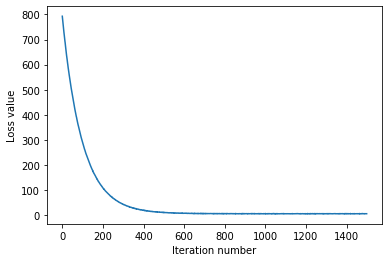

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371041
validation accuracy: 0.373000


In [15]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-7, 1e-7, 5e-5, 5e-5, 5e-5, 3e-6, 3e-6, 3e-6]
regularization_strengths = [2.5e4, 5e4, 1e4, 2.5e4, 5e4, 1e4, 2.5e4, 5e4, 1e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from cs231n.classifiers import LinearSVM

for lr , rg in zip(learning_rates, regularization_strengths):

    # make an svm object
    temp_svm = LinearSVM()

    # train it
    loss_hist = temp_svm.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=True)

    # compute its accuracy on the training and validation sets
    y_train_pred = temp_svm.predict(X_train)
    y_val_pred = temp_svm.predict(X_val)

    training_acc =  (np.mean(y_train == y_train_pred))
    validation_acc = (np.mean(y_val == y_val_pred))

    results[(lr, rg)] = (training_acc, validation_acc)
    
    # if we got a better validation accuracy
    if validation_acc > best_val: 
        best_val = validation_acc
        best_svm = temp_svm

"""

Another approach to build your hyperparameters:
If you want the absolute best results, use this.

Karpathy also told us that the best way to sample hyperparameters is random 
and not grid search.

Because almost always some of the hyperparameters are more 
important than others.

learning_rates = np.geomspace(2e-7, 3e-7, 5)
regularization_strengths = np.geomspace(5e3, 5e4, 5)

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    ...
"""

"""

Or another one:

learning_rates = [1e-7, 1e-6]
regularization_strengths = [2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4, 6e4]

# Obtain all possible combinations
# as a matrix
grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths]

...

"""

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 796.939929
iteration 100 / 1500: loss 290.771004
iteration 200 / 1500: loss 109.660399
iteration 300 / 1500: loss 43.574328
iteration 400 / 1500: loss 18.991513
iteration 500 / 1500: loss 10.831000
iteration 600 / 1500: loss 7.639781
iteration 700 / 1500: loss 5.844643
iteration 800 / 1500: loss 5.273512
iteration 900 / 1500: loss 5.599383
iteration 1000 / 1500: loss 5.864652
iteration 1100 / 1500: loss 4.769567
iteration 1200 / 1500: loss 4.928914
iteration 1300 / 1500: loss 5.615737
iteration 1400 / 1500: loss 5.337067
iteration 0 / 1500: loss 1569.621440
iteration 100 / 1500: loss 212.560674
iteration 200 / 1500: loss 32.397101
iteration 300 / 1500: loss 9.670171
iteration 400 / 1500: loss 6.176296
iteration 500 / 1500: loss 5.190405
iteration 600 / 1500: loss 5.306771
iteration 700 / 1500: loss 5.568368
iteration 800 / 1500: loss 5.425043
iteration 900 / 1500: loss 5.563434
iteration 1000 / 1500: loss 5.356108
iteration 1100 / 1500: loss 5.641315
iteration 

/home/sezai/Documents/learn/cs231n/2022assingments/assignment1/cs231n/classifiers/linear_svm.py:161: RuntimeWarning: overflow encountered in double_scalars
  loss = margins.sum() / N - 1 + reg * np.sum(W**2) # regularized loss
/home/sezai/anaconda3/envs/cs231n/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/sezai/Documents/learn/cs231n/2022assingments/assignment1/cs231n/classifiers/linear_svm.py:161: RuntimeWarning: overflow encountered in square
  loss = margins.sum() / N - 1 + reg * np.sum(W**2) # regularized loss


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1568.356375
iteration 100 / 1500: loss 4196288396595921681736091300489715788505362938664389775597386379999685149301072458231348686064743014158654802199881803890688.000000
iteration 200 / 1500: loss 10835865200527327884298226555981663961786317524994469742796925113749040084727908600657628311066341589356340112952805160839060110095623721406638189570976825425095831972182626371741986753106381830826516381675370216913287974879151829787956308082688.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/home/sezai/anaconda3/envs/cs231n/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/sezai/Documents/learn/cs231n/2022assingments/assignment1/cs231n/classifiers/linear_svm.py:192: RuntimeWarning: overflow encountered in multiply
  dW = X.T @ dW / N + 2 * reg * W
/home/sezai/Documents/learn/cs231n/2022assingments/assignment1/cs231n/classifiers/linear_svm.py:137: RuntimeWarning: invalid value encountered in matmul
  scores = X @ W
/home/sezai/Documents/learn/cs231n/2022assingments/assignment1/cs231n/classifiers/linear_classifier.py:89: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 339.150689
iteration 100 / 1500: loss 654.468691
iteration 200 / 1500: loss 560.776932
iteration 300 / 1500: loss 478.028975
iteration 400 / 1500: loss 628.095620
iteration 500 / 1500: loss 549.784128
iteration 600 / 1500: loss 464.150971
iteration 700 / 1500: loss 472.008566
iteration 800 / 1500: loss 539.541500
iteration 900 / 1500: loss 574.682482
iteration 1000 / 1500: loss 600.288454
iteration 1100 / 1500: loss 531.998883
iteration 1200 / 1500: loss 686.412268
iteration 1300 / 1500: loss 571.057126
iteration 1400 / 1500: loss 698.684634
iteration 0 / 1500: loss 784.816311
iteration 100 / 1500: loss 13.523339
iteration 200 / 1500: loss 12.626845
iteration 300 / 1500: loss 13.979

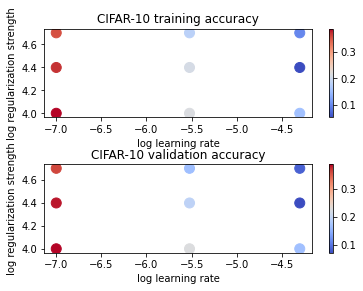

In [16]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [17]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.385000


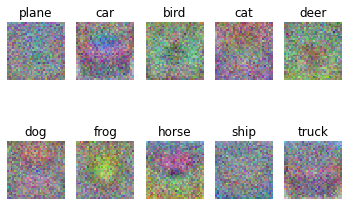

In [18]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  


Description:

The visualized SVM weights for each class look like a combination of different images for that class. Kinda like a generalization of image features in a single image which weights are calculated towards. They are also blurred (if we had a higher accuracy, we could get a better result).

SVM has been trained to identify the distinct features. Frogs are green, ships has a blue background, deers have horns.

Most images of weight visualizations are symmetric - weights are trained to generalize the best. Horse appears with 2 heads.